In [24]:
import pandas as pd
df = pd.read_csv('data/daily_data.csv', parse_dates=True, index_col=0)


## Forecasting (Next 7 Days)

c:\Users\mouad\OneDrive\Desktop\Electricity_Forcast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mouad\OneDrive\Desktop\Electricity_Forcast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 8.050
RMSE: 9.983


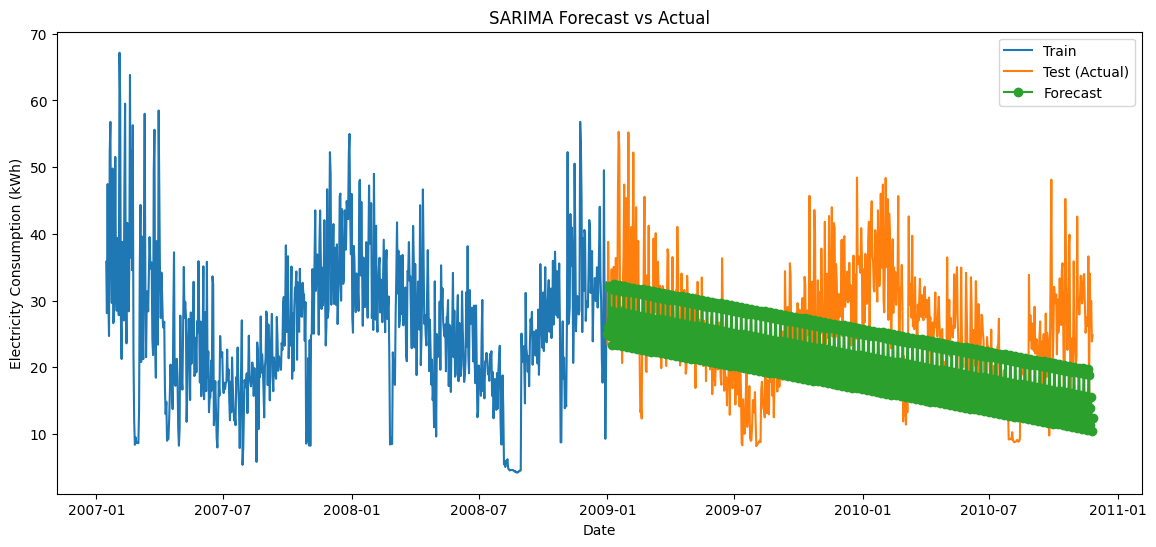

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

target_col = 'kWh'  # or your target column name

# Assuming df_daily is your full dataset with datetime index
split_date = '2009-01-01'  # adjust to your data

train = df[df.index < split_date]
test = df[df.index >= split_date]

# Fit SARIMA model on train
model = SARIMAX(train[target_col], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)

# Forecast on test set length
n_test = len(test)
forecast = model_fit.forecast(steps=n_test)

# Calculate errors
mae = mean_absolute_error(test[target_col], forecast)
rmse = np.sqrt(mean_squared_error(test[target_col], forecast))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot results
plt.figure(figsize=(14,6))
plt.plot(train.index, train[target_col], label='Train')
plt.plot(test.index, test[target_col], label='Test (Actual)')
plt.plot(test.index, forecast, label='Forecast', marker='o')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kWh)')
plt.legend()
plt.show()


In [26]:
df['kWh'].mean()

np.float64(25.845668071293677)

In [27]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 7  # weekly seasonality

# Generate all parameter combinations
seasonal_pdq = list(itertools.product(P, D, Q, [s]))
pdq = list(itertools.product(p, d, q))

# Silence warnings
warnings.filterwarnings("ignore")

best_aic = float('inf')
best_params = None

# Loop over combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train['kWh'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

print(f"✅ Best SARIMA order: {best_params[0]}, seasonal order: {best_params[1]}, AIC: {best_aic:.2f}")


✅ Best SARIMA order: (1, 1, 1), seasonal order: (0, 1, 1, 7), AIC: 4783.04


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_model = SARIMAX(train['kWh'],
                     order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 7))
best_fit = best_model.fit(disp=False)


In [29]:
forecast = best_fit.forecast(steps=len(test))


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['kWh'], forecast)
rmse = np.sqrt(mean_squared_error(test['kWh'], forecast))

print(f"📊 MAE: {mae:.3f}")
print(f"📊 RMSE: {rmse:.3f}")


📊 MAE: 6.903
📊 RMSE: 8.730


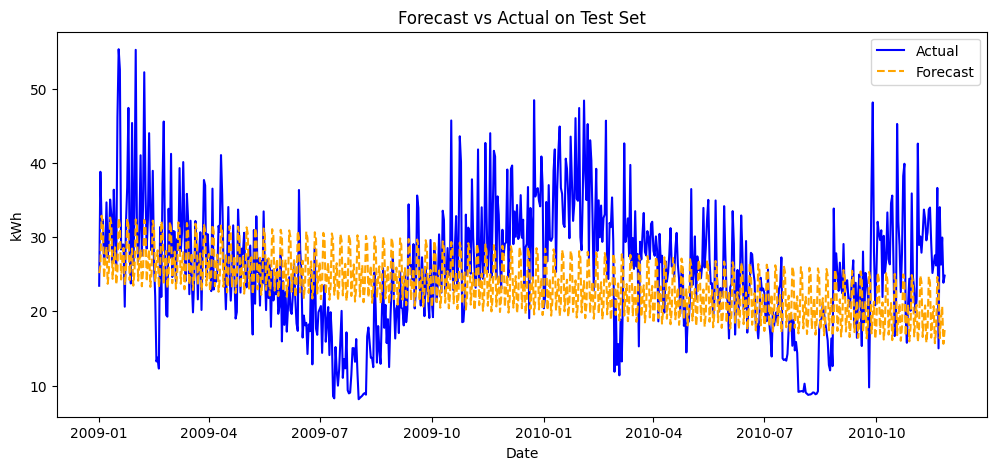

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test.index, test['kWh'], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='orange', linestyle='--')
plt.title('Forecast vs Actual on Test Set')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()


In [44]:
df_prophet = df.copy()
df_prophet['ds'] = df_prophet.index
df_prophet = df_prophet[['ds', 'kWh']].rename(columns={'kWh': 'y'})

In [45]:
print(df_prophet.head())
print(df_prophet.dtypes)


                   ds          y
Datetime                        
2007-01-15 2007-01-15  35.811300
2007-01-16 2007-01-16  28.106733
2007-01-17 2007-01-17  47.461467
2007-01-18 2007-01-18  30.357700
2007-01-19 2007-01-19  24.674000
ds    datetime64[ns]
y            float64
dtype: object


In [46]:
from prophet import Prophet

model = Prophet()
model.fit(df_prophet)


20:16:55 - cmdstanpy - INFO - Chain [1] start processing
20:16:57 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Forecast the next 30 days (or change periods as needed)
future = model.make_future_dataframe(periods=30)


In [48]:
forecast = model.predict(future)


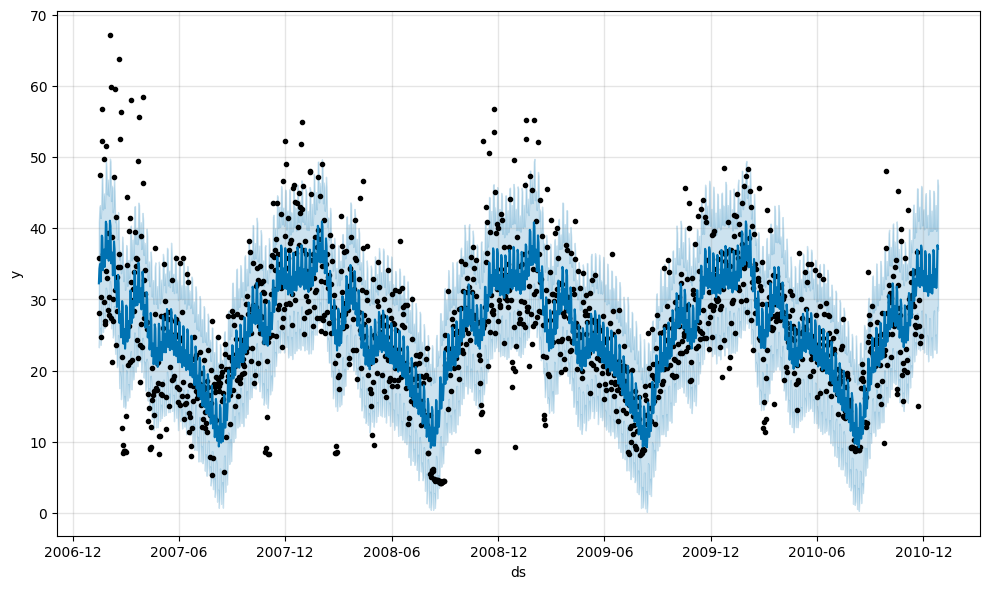

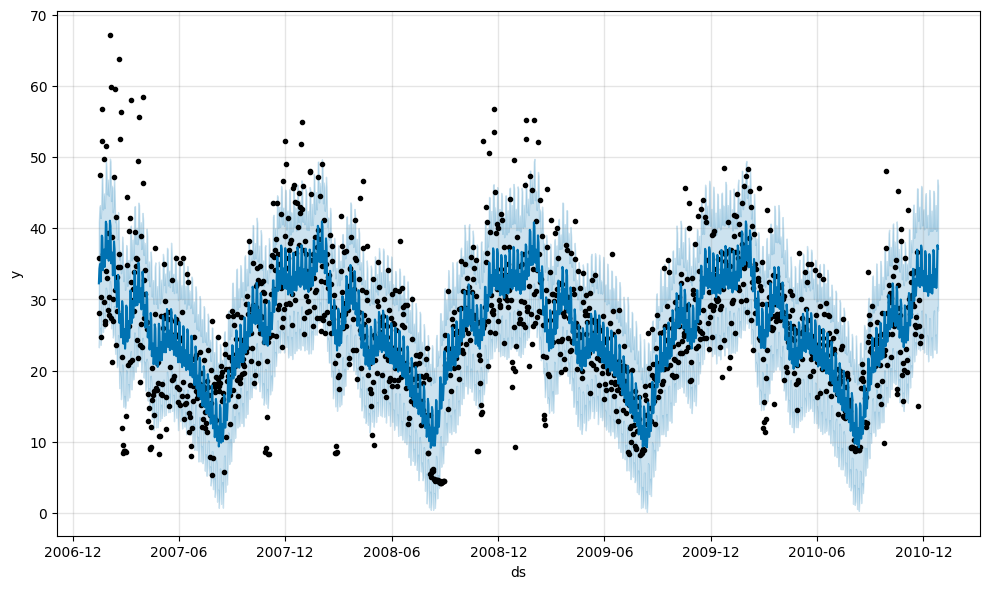

In [49]:
model.plot(forecast)


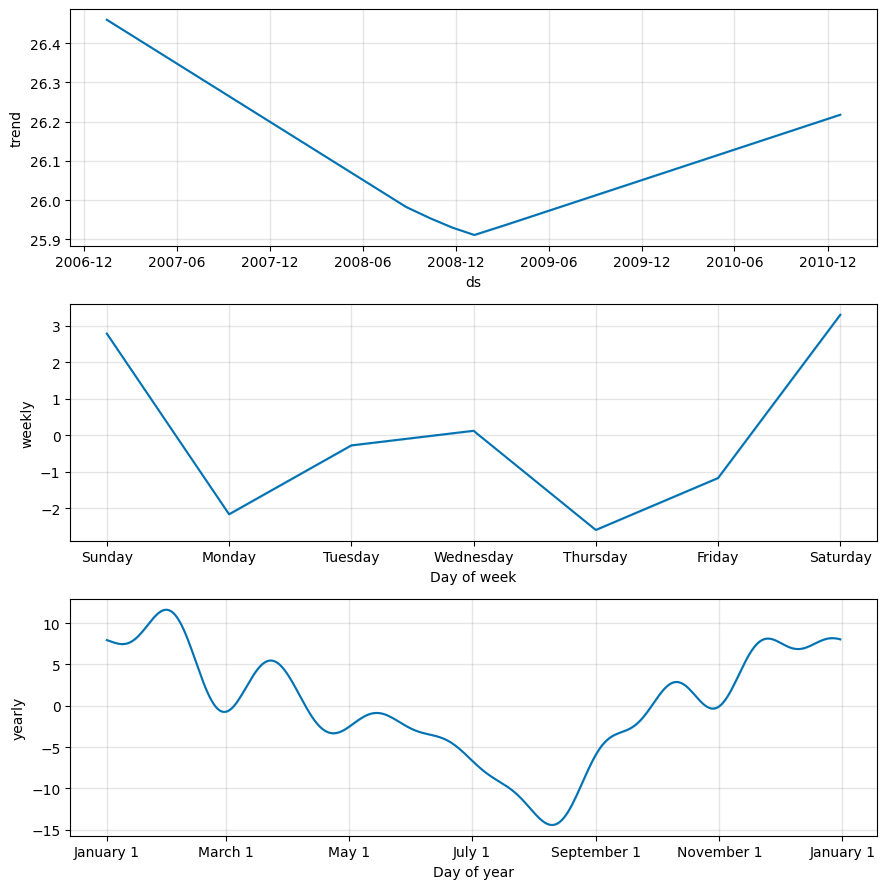

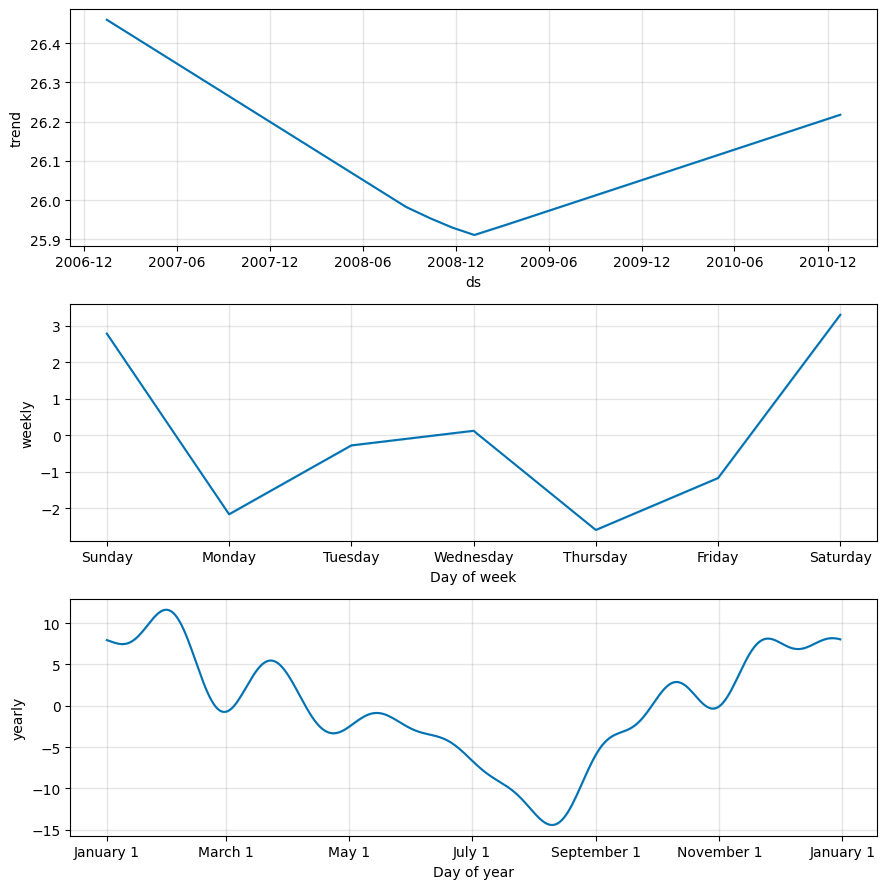

In [50]:
model.plot_components(forecast)


In [51]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1437,2010-12-22,34.238554,25.072290,43.254467
1438,2010-12-23,31.613388,22.472363,39.638596
1439,2010-12-24,33.110654,24.039650,41.953641
1440,2010-12-25,37.639293,28.970459,46.875398
1441,2010-12-26,37.160679,28.450836,46.021460
